### Loading libraries

In [221]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

%matplotlib inline

### Loading images

In [222]:
'''import os
def readImages(dir, format):
    
    images = []
    for dirpath, dirnames, filenames in os.walk(dir):
        for dirname in dirnames:
            images.append(glob.glob(dir + '/' + dirname + '/' + format))
    flatten = [item for sublist in images for item in sublist]
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), format))
vehicles = readImages('./Trainingdatasets/vehicles', '*.png')
non_vehicles = readImages('./Trainingdatasets/non-vehicles', '*.png')'''

vehc = glob.glob('./Trainingdatasets/vehicles/**/*.png')
non_vehc = glob.glob('./Trainingdatasets/non-vehicles/**/*.png')

import cv2
import numpy as np

car = []
for i in range(len(vehc)):
    img = cv2.cvtColor(cv2.imread(vehc[i]), cv2.COLOR_BGR2RGB)
    #img = mpimg.imread(vehc[i])
    car.append(img)

non_car = []
for i in range(len(non_vehc)):
    img = cv2.cvtColor(cv2.imread(non_vehc[i]), cv2.COLOR_BGR2RGB)
    non_car.append(img)

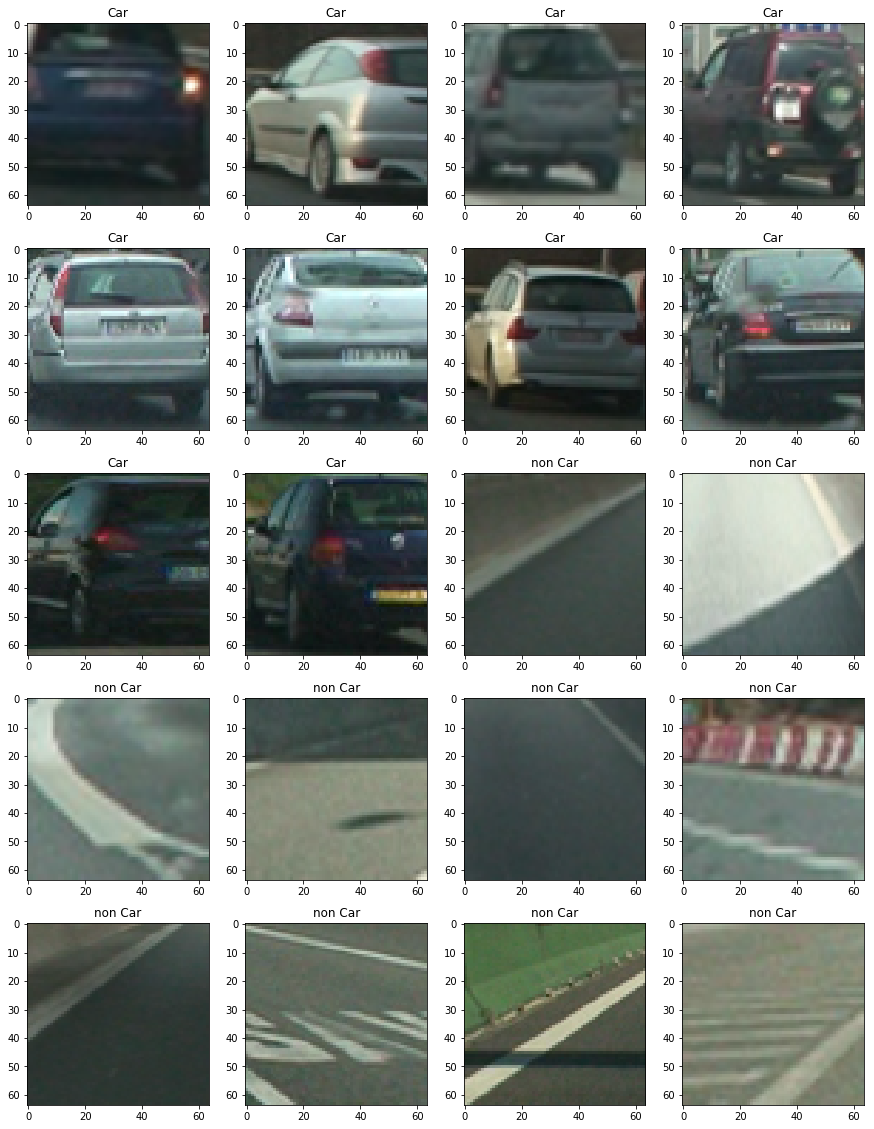

In [41]:
plt.figure(figsize = (15,20))
k = 1
while k < 11:
    plt.subplot(5,4,k)
    plt.imshow(car[k])
    plt.title('Car')
    plt.subplot(5,4,k+10)
    plt.imshow(non_car[k])
    plt.title('non Car')
    k = k+1

## Feature extraction

### Defining required functins from the course

In [42]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Defining the parameters
class FeaturesParameters():
    def __init__(self):
        # HOG parameters
        self.cspace = 'YCrCb'
        self.orient = 8
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        # Bin spatial parameters
        self.size = (16, 16)
        # Histogram parameters
        self.hist_bins = 32
        self.hist_range = (0, 256)
        
def extract_features(image, params ):
    # Parameters extraction
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size)

    # Apply color_hist() 
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    return np.concatenate((spatial_features, hist_features, hog_features))

#### This cell was used to identified the best extracted featires for teh machine learning on the subset of the data

In [ ]:
'''conditions = []
colSpace = {'RGB','HLS','LUV','YUV','YCrCb'}
orient = [6,9,12]
pixPcell = [8,16]
cellPblock = [1,2,3]
HOGChannel = {0,1,2,'ALL'}
for i in colSpace:
    for j in orient:
        for k in pixPcell:
            for m in cellPblock:
                for n in HOGChannel:
                    car_features = extract_features(car,
                                                    cspace=i,
                                                    orient=j,
                                                    pix_per_cell=k,
                                                    cell_per_block=m,
                                                    hog_channel=n)
                    notcar_features = extract_features(non_car,
                                                       cspace=i,
                                                       orient=j,pix_per_cell=k,
                                                       cell_per_block=m,
                                                       hog_channel=n)
                    X = np.vstack((car_features, notcar_features)).astype(np.float64)
                    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    
                    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                        y, 
                                                                        test_size=0.2,
                                                                        random_state=3)
                    clf = clf.fit(X_train, y_train)
                    
                    score = clf.score(X_test[0:20],y_test[0:20])
                    
                    print([i,j,k,m,n,score])
                    cond = [i,j,k,m,n,score]
                    conditions.append(cond)'''

In [43]:
def model_fit( car, non_car, svc, scaler, params ):

    positive_features = list(map(lambda img: extract_features(img, params), car))
    negatice_features = list(map(lambda img: extract_features(img, params), non_car))
    
    # Stacking and scaling
    X = np.vstack((positive_features, negatice_features)).astype(np.float64)    
    X_scaler = scaler.fit(X)
    scaled_X = X_scaler.transform(X)
    
    # Defining objective
    y = np.hstack((np.ones(len(positive_features)), np.zeros(len(negatice_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X,
                                                        y, 
                                                        test_size=0.2,
                                                        random_state=rand_state)
    
    # Fitting
    svc.fit(X_train, y_train)
    accuracy = round(svc.score(X_test, y_test),4)
    return (svc, X_scaler, accuracy)

In [45]:
params = FeaturesParameters()
svc, scaler, accuracy = model_fit(vehicles, non_vehicles, LinearSVC(), StandardScaler(), params)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.9916


Text(0.5,1,'HOG - Cb')

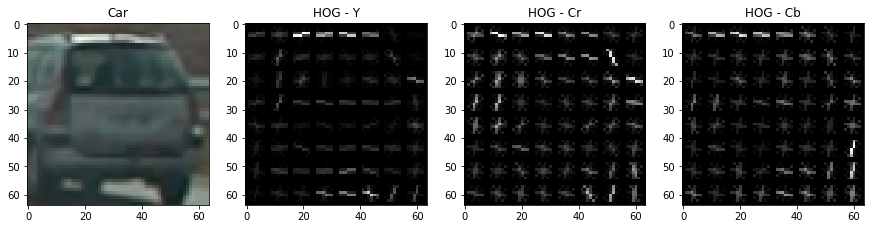

In [55]:
img_cspaced = cv2.cvtColor(car[0], cv2.COLOR_RGB2YCrCb)
_, hog_y = get_hog_features(img_cspaced[:,:,0], 
                            params.orient, params.pix_per_cell, params.cell_per_block, 
                            vis=True, feature_vec=True)
_, hog_Cr = get_hog_features(img_cspaced[:,:,1], 
                            params.orient, params.pix_per_cell, params.cell_per_block, 
                            vis=True, feature_vec=True)
_, hog_Cb = get_hog_features(img_cspaced[:,:,2], 
                            params.orient, params.pix_per_cell, params.cell_per_block,
                            vis=True, feature_vec=True)
fig, axes = plt.subplots(ncols=4, figsize=(15,15))
axes[0].imshow(car[0])
axes[0].set_title('Car')
axes[1].imshow(hog_y, cmap='gray')
axes[1].set_title('HOG - Y')
axes[2].imshow(hog_Cr, cmap='gray')
axes[2].set_title('HOG - Cr')
axes[3].imshow(hog_Cb, cmap='gray')
axes[3].set_title('HOG - Cb')

Text(0.5,1,'HOG - Cb')

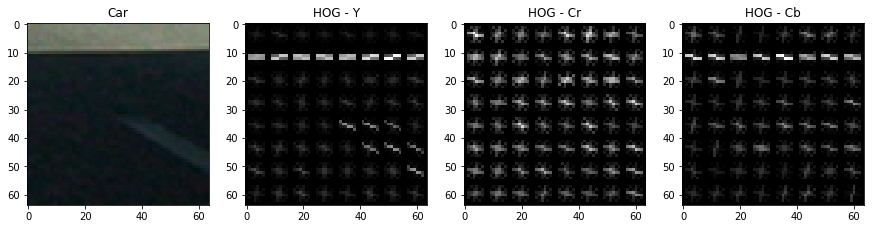

In [56]:
img_cspaced = cv2.cvtColor(non_car[0], cv2.COLOR_RGB2YCrCb)
_, hog_y = get_hog_features(img_cspaced[:,:,0], 
                            params.orient, params.pix_per_cell, params.cell_per_block, 
                            vis=True, feature_vec=True)
_, hog_Cr = get_hog_features(img_cspaced[:,:,1], 
                            params.orient, params.pix_per_cell, params.cell_per_block, 
                            vis=True, feature_vec=True)
_, hog_Cb = get_hog_features(img_cspaced[:,:,2], 
                            params.orient, params.pix_per_cell, params.cell_per_block,
                            vis=True, feature_vec=True)
fig, axes = plt.subplots(ncols=4, figsize=(15,15))
axes[0].imshow(non_car[0])
axes[0].set_title('Car')
axes[1].imshow(hog_y, cmap='gray')
axes[1].set_title('HOG - Y')
axes[2].imshow(hog_Cr, cmap='gray')
axes[2].set_title('HOG - Cr')
axes[3].imshow(hog_Cb, cmap='gray')
axes[3].set_title('HOG - Cb')

### Function provided by udacity course for creating sliding windows

In [9]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [10]:
test_images = list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), glob.glob('./test_images/*.jpg')))

In [57]:
def findCarWindows(img, clf, scaler, params, y_start_stop=[360, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):

    car_windows = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window, params)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = clf.predict(scaled_features)
        if pred == 1:
            car_windows.append(window)
    return car_windows

def drawCars(img, windows):

    output = np.copy(img)
    return draw_boxes(output, windows)

In [58]:
car_tst = list(map(lambda img: drawCars(img, findCarWindows(img, svc, scaler, params)), test_images))

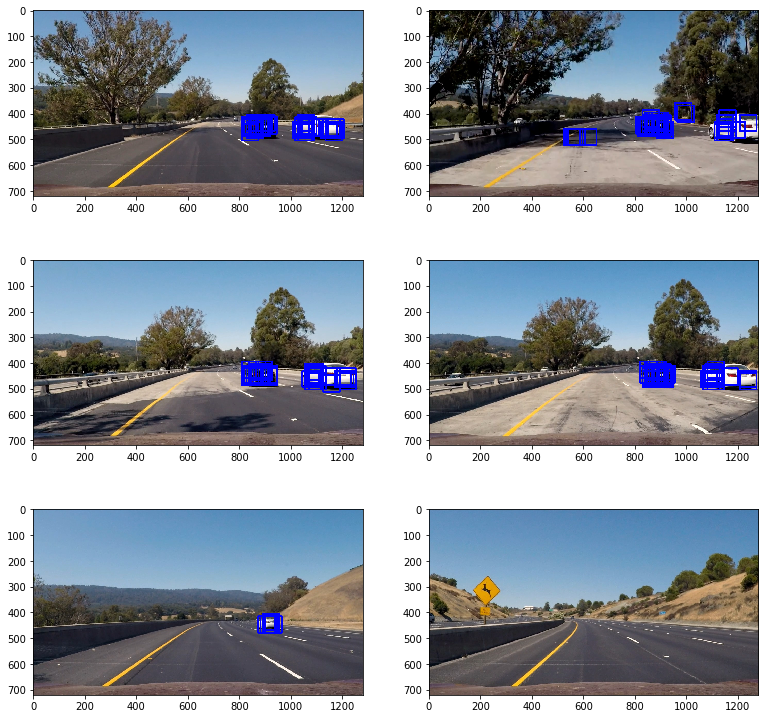

In [77]:

j = 1
plt.figure(figsize = (13,13))
for i in car_tst:
    plt.subplot(3,2,j)
    plt.imshow(i)
    j = j+1


### Heatmap functions from the course

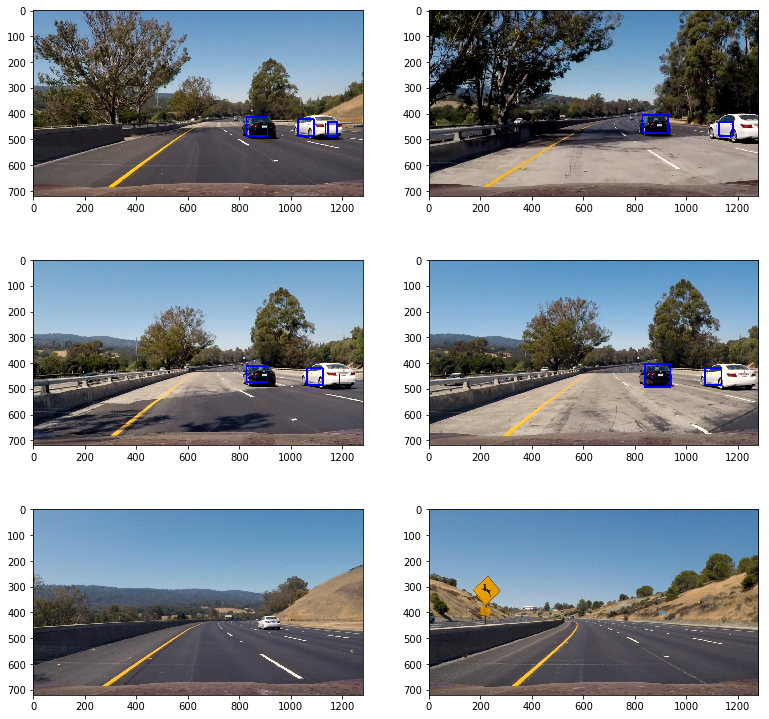

In [98]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

from scipy.ndimage.measurements import label

def drawCarsWithLabels(img, boxes, threshHold = 6):
    
    heatmap = add_heat(np.zeros(img.shape), boxes)
    heatmap = apply_threshold(heatmap, threshHold)
    labels = label(heatmap)
    
    return draw_labeled_bboxes(np.copy(img), labels)
    
boxed_on_test = list(map(lambda img: drawCarsWithLabels(img, findCarWindows(img, svc, scaler, params)), test_images))

#showImages(boxed_on_test)

j = 1
plt.figure(figsize = (13,13))
for i in boxed_on_test:
    plt.subplot(3,2,j)
    plt.imshow(i)
    j = j+1

### Subsampling for preformance improvement

/Users/Arash/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/Users/Arash/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


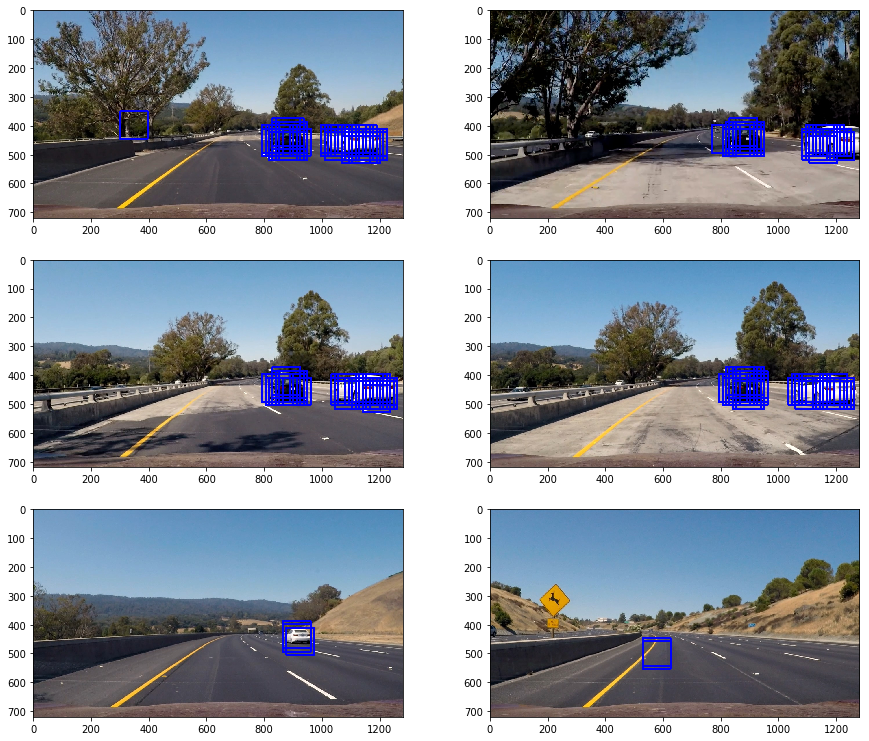

In [21]:
def findBoxes(img, clf, scaler, params, y_start_stop=[350, 656], window=64, cells_per_step=1, scale=1.5 ):

    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    
    # Image color space changes
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    ystart, ystop = y_start_stop
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            
            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

fast_boxes = list(map(lambda img: findBoxes(img, svc, scaler, params), test_images))

fast_on_test = list(map(lambda imgAndBox: drawCars(imgAndBox[0], imgAndBox[1]), zip(test_images, fast_boxes)))

j = 1
plt.figure(figsize = (13,13))
for i in fast_on_test:
    plt.subplot(3,2,j)
    plt.imshow(i)
    j = j+1

### Tuning the hyper-parameters

In [185]:
'''def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap'''

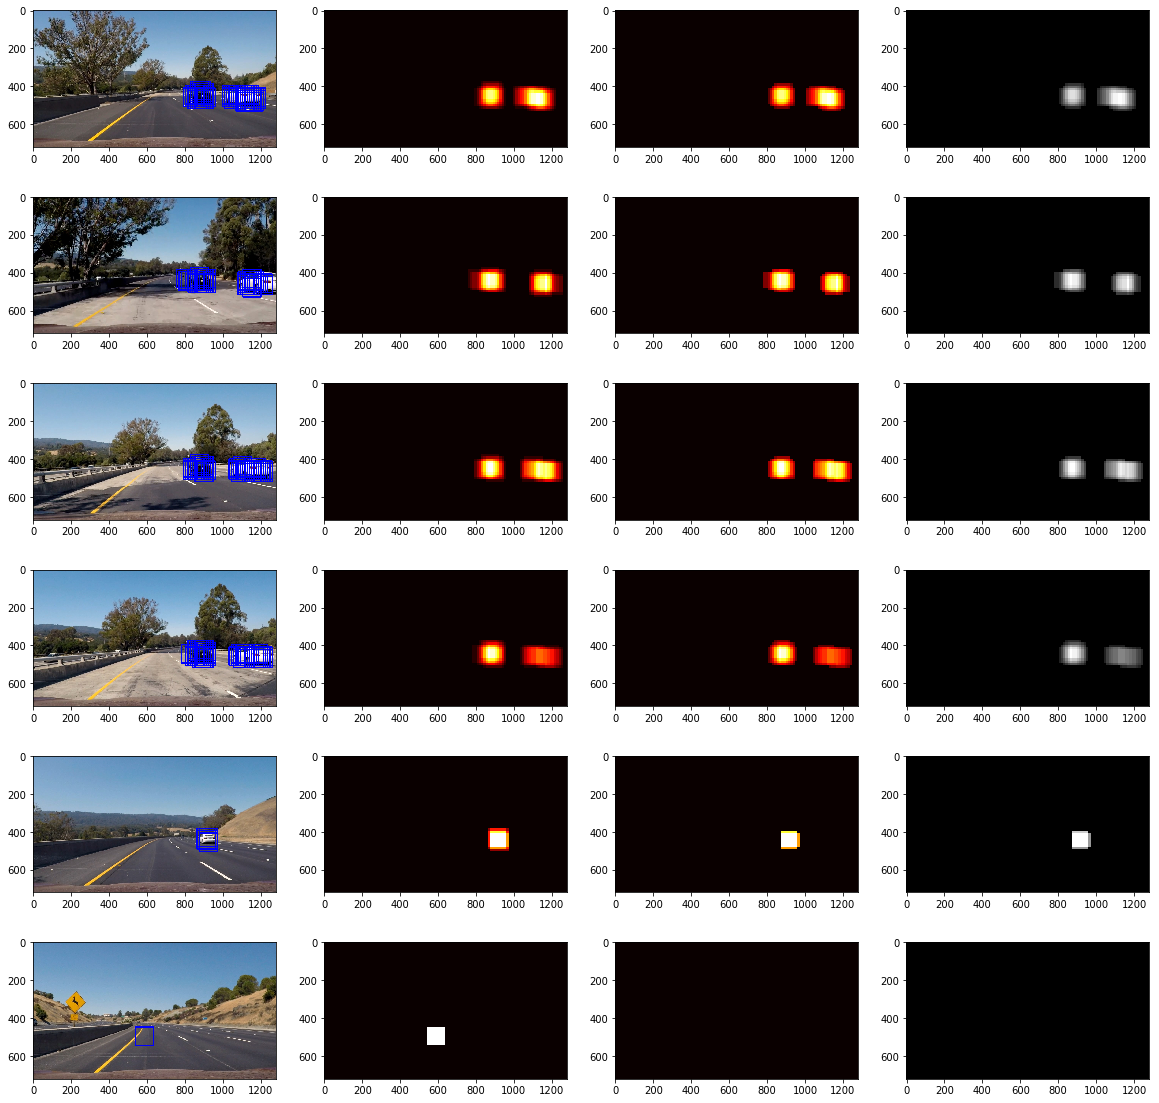

In [210]:
fast_boxes = list(map(lambda img: findBoxes(img, svc, scaler, params), test_images))

fast_on_test = list(map(lambda imgAndBox: drawCars(imgAndBox[0], imgAndBox[1]), zip(test_images, fast_boxes)))

j = 1
plt.figure(figsize = (20,20))
hm = []
for i in fast_on_test:
    plt.subplot(6,4,((4*j)-3))
    plt.imshow(i)
    a = findBoxes(test_images[j-1], svc, scaler, params)
    nnp = np.array(test_images[j-1])
    heatmap_img = np.zeros_like(nnp[:,:,0])
    heatmap_img = add_heat(heatmap_img, a)
    plt.subplot(6,4,((4*j)-2))
    plt.imshow(heatmap_img, cmap = 'hot')
    hm = apply_threshold(heatmap_img, 2)
    plt.subplot(6,4,((4*j)-1))
    plt.imshow(hm, cmap = 'hot')
    plt.subplot(6,4,((4*j)))
    labels = label(hm)
    plt.imshow(hm, cmap='gray')
    j = j+1

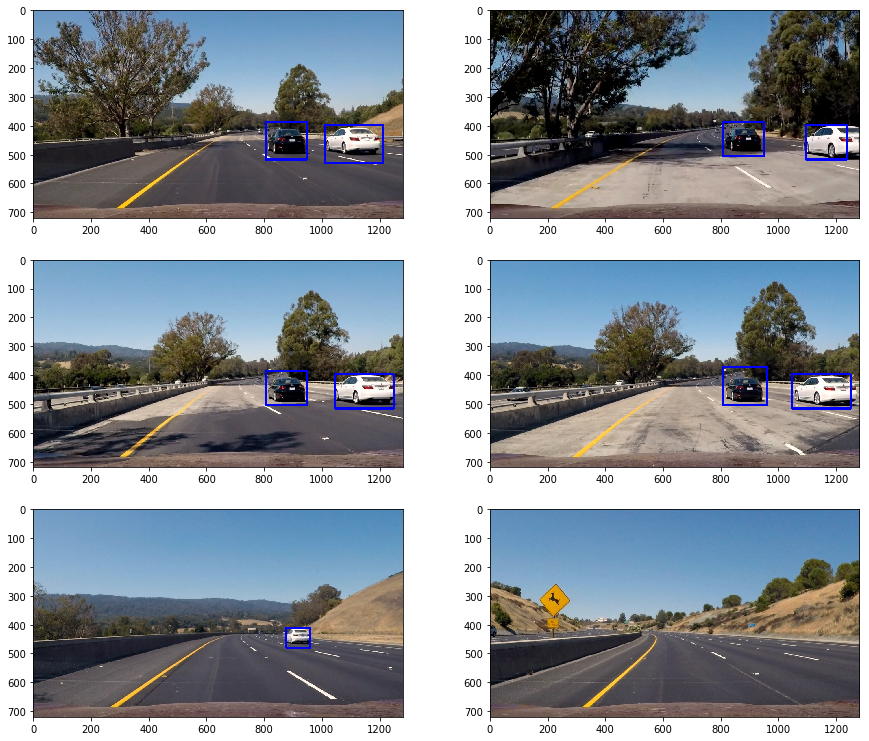

In [25]:
fast_on_test = list(map(lambda imgAndBox: drawCarsWithLabels(imgAndBox[0], imgAndBox[1], threshHold=2), zip(test_images, fast_boxes)))

j = 1
plt.figure(figsize = (13,13))
for i in fast_on_test:
    plt.subplot(3,2,j)
    plt.imshow(i)
    j = j+1

### Video pipeline

In [211]:
'''from moviepy.editor import VideoFileClip
from functools import reduce



def processVideo(inputVideo, outputVideo, frames_to_remember=3, threshhold=1):
    """
    Process the video `inputVideo` to find the cars and saves the video to `outputVideo`.
    """
    #history = []#HeatHistory()

    def pipeline(img):
        boxes = findBoxes(img, svc, scaler, params)
        img_shape = img.shape
        heatmap = add_heat(np.zeros(img_shape), boxes)
        if len(history) >= frames_to_remember:
            history = history[1:]

        heatmap = apply_threshold(heat_history, threshhold)
        labels = label(heatmap)

        return draw_labeled_bboxes(np.copy(img), labels)

    myclip = VideoFileClip(inputVideo)
    output_video = myclip.fl_image(pipeline)
    output_video.write_videofile(outputVideo, audio=False)
    
processVideo('./project_video.mp4', './project_video_output.mp4', threshhold=2)'''

'from moviepy.editor import VideoFileClip\nfrom functools import reduce\n\n\n\ndef processVideo(inputVideo, outputVideo, frames_to_remember=3, threshhold=1):\n    """\n    Process the video `inputVideo` to find the cars and saves the video to `outputVideo`.\n    """\n    #history = []#HeatHistory()\n\n    def pipeline(img):\n        boxes = findBoxes(img, svc, scaler, params)\n        img_shape = img.shape\n        heatmap = add_heat(np.zeros(img_shape), boxes)\n        if len(history) >= frames_to_remember:\n            history = history[1:]\n\n        heatmap = apply_threshold(heat_history, threshhold)\n        labels = label(heatmap)\n\n        return draw_labeled_bboxes(np.copy(img), labels)\n\n    myclip = VideoFileClip(inputVideo)\n    output_video = myclip.fl_image(pipeline)\n    output_video.write_videofile(outputVideo, audio=False)\n    \nprocessVideo(\'./project_video.mp4\', \'./project_video_output.mp4\', threshhold=2)'

In [214]:
def pipeline(img):
    
    fast_boxes = list(map(lambda img: findBoxes(img, svc, scaler, params), test_images))
    fast_on_test = list(map(lambda imgAndBox: drawCarsWithLabels(imgAndBox[0], imgAndBox[1], threshHold=2), zip(img, fast_boxes)))

    return fast_on_test

a=pipeline(test_images[6])

IndexError: list index out of range

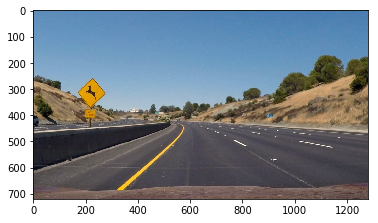

In [217]:
plt.imshow(a[5])

In [220]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

AttributeError: 'list' object has no attribute 'fl_image'